In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!ls drive/MyDrive/Colab\ Notebooks/Литос

dataset_2_Litos.zip  Data_set_Litos_13Jun23.zip  разметка.csv
dataset_3_Litos.zip  Литос


In [3]:
!unzip -q /content/drive/MyDrive/Colab\ Notebooks/Литос/dataset_3_Litos.zip

In [ ]:
!ls dataset_3_Litos

test  train


In [ ]:
!ls dataset_3_Litos/train

1  2  3  4


In [ ]:
!ls dataset_3_Litos/test

1  2  3  4


In [4]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
!nvidia-smi
torch.cuda.is_available()

Sat Jul  1 15:46:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [6]:
!pip install torchsampler
from torchsampler import ImbalancedDatasetSampler

In [7]:
import pickle
import numpy as np
import pandas as pd
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.nn as nn
from torch.nn import functional as F


from matplotlib import colors, pyplot as plt
%matplotlib inline

import tensorflow as tf

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [8]:
torch.manual_seed(0)

In [9]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

In [35]:
class LitosDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def get_labels(self):
        return self.labels

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):

        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.Grayscale(num_output_channels=3),
                # transforms.RandomHorizontalFlip(p=0.7),
                # transforms.RandomRotation(25),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.Grayscale(num_output_channels=3),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])

        x = self.load_sample(self.files[index])

        x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))

        return np.array(image)

In [36]:
TRAIN_DIR = Path('dataset_3_Litos/train')
TEST_DIR = Path('dataset_3_Litos/test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.JPG')))
test_files = sorted(list(TEST_DIR.rglob('*.JPG')))

In [12]:
print(train_val_files)

[PosixPath('dataset_3_Litos/train/1/4191.JPG'), PosixPath('dataset_3_Litos/train/1/4192.JPG'), PosixPath('dataset_3_Litos/train/1/4193.JPG'), PosixPath('dataset_3_Litos/train/1/4194.JPG'), PosixPath('dataset_3_Litos/train/1/4195.JPG'), PosixPath('dataset_3_Litos/train/1/4218.JPG'), PosixPath('dataset_3_Litos/train/1/4224.JPG'), PosixPath('dataset_3_Litos/train/1/4233.JPG'), PosixPath('dataset_3_Litos/train/1/4234.JPG'), PosixPath('dataset_3_Litos/train/1/4235.JPG'), PosixPath('dataset_3_Litos/train/1/4239.JPG'), PosixPath('dataset_3_Litos/train/1/4241.JPG'), PosixPath('dataset_3_Litos/train/1/4243.JPG'), PosixPath('dataset_3_Litos/train/1/4252.JPG'), PosixPath('dataset_3_Litos/train/1/4255.JPG'), PosixPath('dataset_3_Litos/train/1/4263.JPG'), PosixPath('dataset_3_Litos/train/1/4264.JPG'), PosixPath('dataset_3_Litos/train/1/4297.JPG'), PosixPath('dataset_3_Litos/train/1/4298.JPG'), PosixPath('dataset_3_Litos/train/1/4300.JPG'), PosixPath('dataset_3_Litos/train/1/4301.JPG'), PosixPath('d

In [37]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files, train_labels, val_labels = train_test_split(train_val_files, train_val_labels, test_size=0.25, \
                                          stratify=train_val_labels, shuffle=True, random_state=1)

In [14]:
n_classes = len(np.unique(train_val_labels))
n_classes

4

In [15]:
print(len(train_files), len(val_files))

87 29


In [16]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    plt_ax.imshow(inp.permute(1, 2, 0))

    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [17]:
def preview(dataset):
    fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                            sharey=True, sharex=True)
    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0, len(dataset)))
        im_val, label = dataset[random_characters]
        img_label = " ".join(map(lambda x: x.capitalize(),\
                    dataset.label_encoder.inverse_transform([label])[0].split('_')))
        imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

In [38]:
val_dataset = LitosDataset(val_files, mode='val')
train_dataset = LitosDataset(train_files, mode='train')

In [20]:
# Посмотрим на распределение классов в датасете
train_labels = train_dataset.labels
Data_frame = pd.DataFrame({'names': train_labels})
Data_frame.groupby(['names'])['names'].count()

names
1    17
2    22
3    22
4    26
Name: names, dtype: int64

In [21]:
print(val_dataset[0][0].shape)

torch.Size([3, 224, 224])


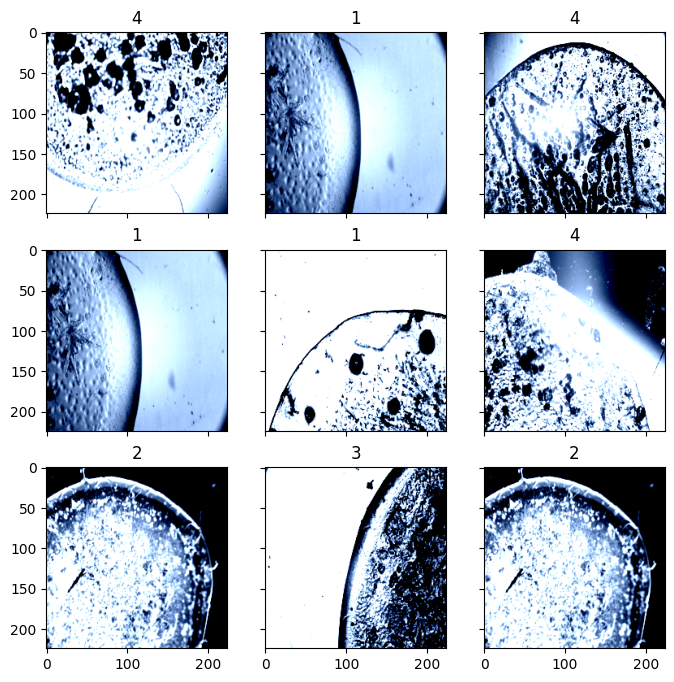

In [39]:
preview(train_dataset)

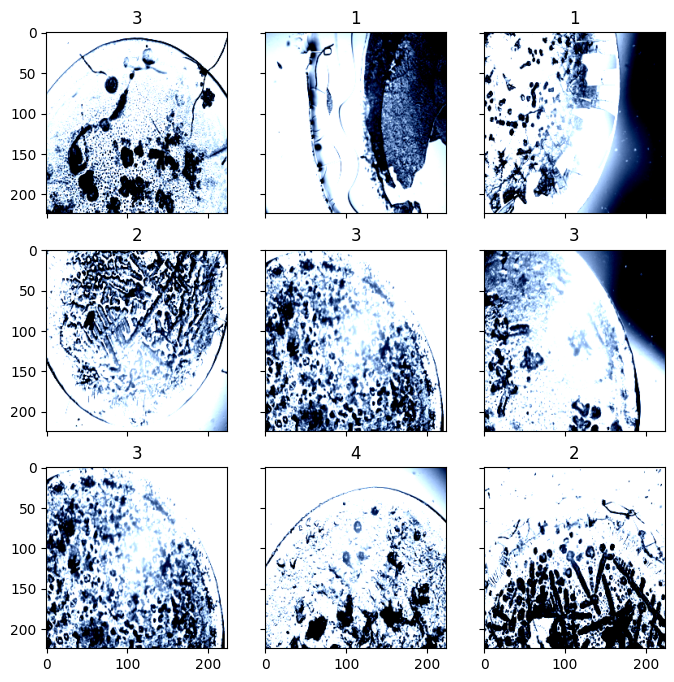

In [40]:
preview(val_dataset)

In [24]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [25]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [32]:
# Применяю сэмплер ImbalancedDatasetSampler для сбалансирования классов в тренеровочно наборе
# методом oversampling и undersampling с удержанием исходного количества данных

def train(train_files, val_files, model,  epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=ImbalancedDatasetSampler(train_dataset))
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [27]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [28]:
def get_model():
  model = models.resnet50(weights=models.ResNet50_Weights)

  # Заморозка слоев (буду замораживать первые 6 слоев)
  count = 1
  for child in model.children():
    if count < 7:
      for param in child.parameters():
          param.requires_grad = False
    count += 1

  # Замена выходного слоя
  model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(model.fc.in_features, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, n_classes)
  )

  model = model.cuda() if torch.cuda.is_available() else model
  model.fc = model.fc.cuda() if torch.cuda.is_available() else model.fc

  return model

In [41]:
model = get_model()
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [42]:
torch.backends.cudnn.benchmark = True

In [43]:
history = train(train_dataset, val_dataset, model=model, epochs=10, batch_size=64)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.3715711804642075


epoch:  10%|█         | 1/10 [00:23<03:35, 23.93s/it]


Epoch 001 train_loss: 1.3716     val_loss 1.3865 train_acc 0.2989 val_acc 0.2069
loss 1.3550651731162235


epoch:  20%|██        | 2/10 [00:48<03:14, 24.37s/it]


Epoch 002 train_loss: 1.3551     val_loss 1.3302 train_acc 0.4253 val_acc 0.3793
loss 1.1734324090782253


epoch:  30%|███       | 3/10 [01:13<02:52, 24.58s/it]


Epoch 003 train_loss: 1.1734     val_loss 1.2024 train_acc 0.6092 val_acc 0.3793
loss 1.0796192761125236


epoch:  40%|████      | 4/10 [01:38<02:28, 24.72s/it]


Epoch 004 train_loss: 1.0796     val_loss 1.3691 train_acc 0.6437 val_acc 0.4483
loss 0.879859681787162


epoch:  50%|█████     | 5/10 [02:02<02:02, 24.56s/it]


Epoch 005 train_loss: 0.8799     val_loss 1.3225 train_acc 0.6897 val_acc 0.3103
loss 0.744141273799984


epoch:  60%|██████    | 6/10 [02:26<01:37, 24.35s/it]


Epoch 006 train_loss: 0.7441     val_loss 1.6077 train_acc 0.7356 val_acc 0.3793
loss 0.8214916744451414


epoch:  70%|███████   | 7/10 [02:51<01:13, 24.56s/it]


Epoch 007 train_loss: 0.8215     val_loss 1.0559 train_acc 0.6552 val_acc 0.5172
loss 0.3764538497760378


epoch:  80%|████████  | 8/10 [03:16<00:49, 24.59s/it]


Epoch 008 train_loss: 0.3765     val_loss 1.5547 train_acc 0.8966 val_acc 0.4483
loss 0.3808308491247824


epoch:  90%|█████████ | 9/10 [03:41<00:24, 24.76s/it]


Epoch 009 train_loss: 0.3808     val_loss 1.1287 train_acc 0.8736 val_acc 0.5862
loss 0.1862289597248209


epoch: 100%|██████████| 10/10 [04:06<00:00, 24.61s/it]


Epoch 010 train_loss: 0.1862     val_loss 1.6724 train_acc 0.9540 val_acc 0.4138


In [44]:
loss, acc, val_loss, val_acc = zip(*history)

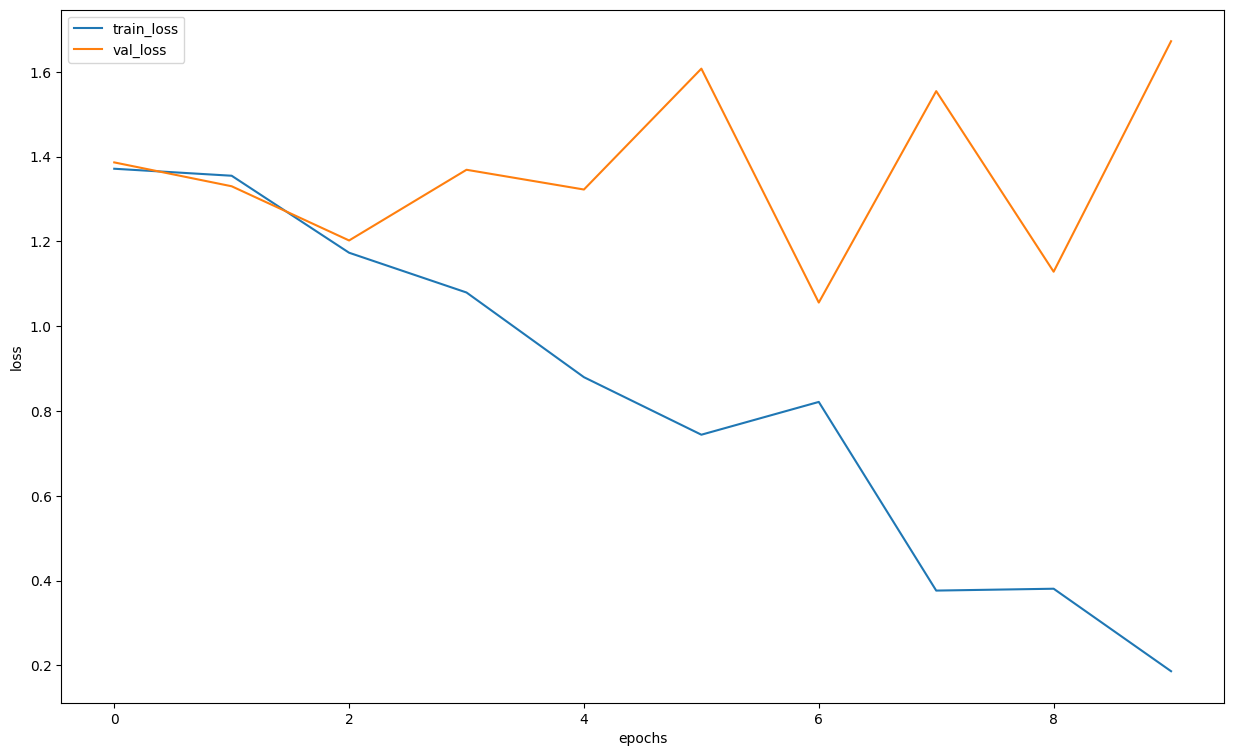

In [45]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [46]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [47]:
random_characters = int(np.random.uniform(0, len(val_dataset)))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [48]:
idxs = list(map(int, np.random.uniform(0, len(val_dataset), 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [49]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [50]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [51]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [label_encoder.inverse_transform([val_dataset[id][1]]).item() for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

from sklearn.metrics import classification_report
print(classification_report(actual_labels, preds_class))

              precision    recall  f1-score   support

           1       0.67      0.67      0.67         3
           2       0.20      0.20      0.20         5
           3       0.30      0.50      0.37         6
           4       1.00      0.33      0.50         6

    accuracy                           0.40        20
   macro avg       0.54      0.42      0.44        20
weighted avg       0.54      0.40      0.41        20



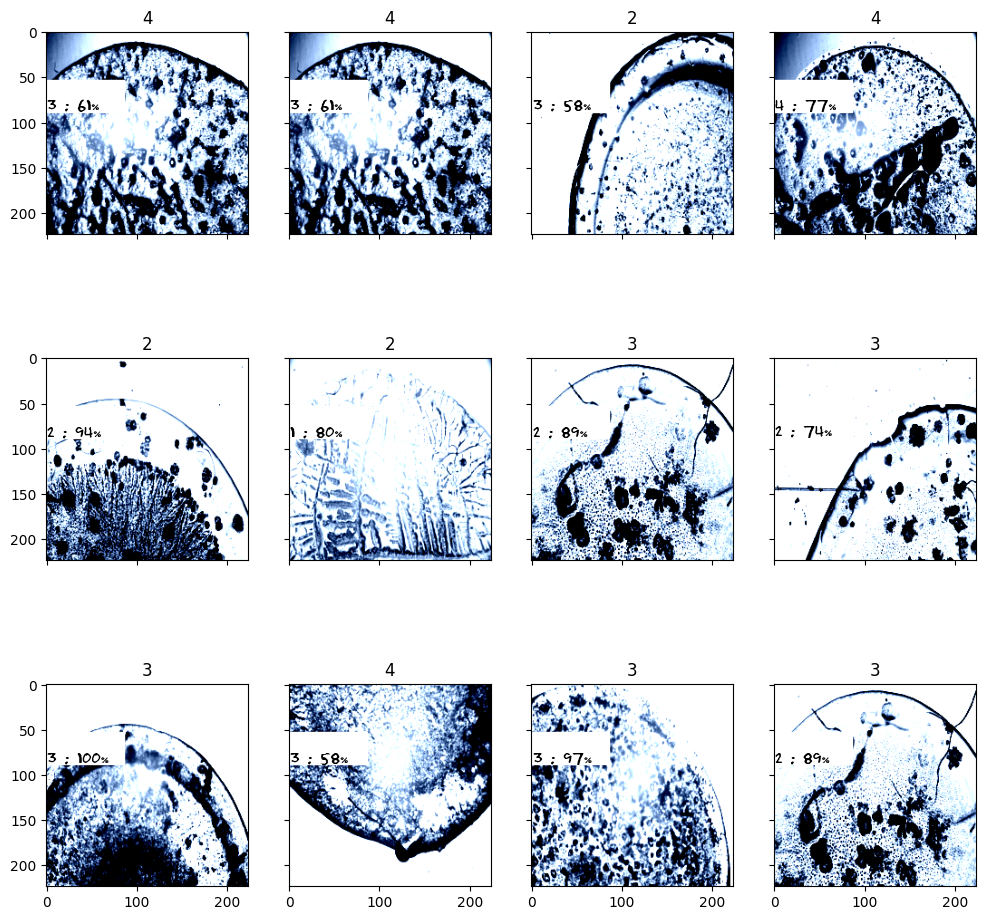

In [53]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=4,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,len(val_dataset)))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=12, color='black')